# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

<ErrorbarContainer object of 3 artists>

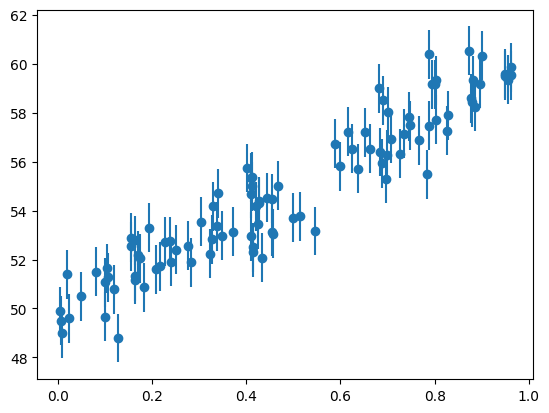

In [29]:
N = 100  # number of points
m = 10.  # slope
b = 50.  # intercept
sigma = 1.  # scatter

rng = np.random.default_rng()
x =  np.array(rng.random(N)) # complete with random values between 0 and 1
y = np.array((m*x+b)) + np.array(rng.normal(loc=0, scale=sigma, size=N)) # equation for a line PLUS random values from a Gaussian centered at 0 with standard deviation `sigma`
dy = np.ones(N) # array of error bars for all the data (all `sigma`)
plt.errorbar(x, y, yerr=dy, fmt="o")

# plot your generated data with error bars

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [30]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

theta = [m,b]

def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """
    if theta[0] > m_min and theta[0] < m_max and theta[1] > b_min and theta[1] < b_max:
        ln_prior = 0
    else:
        ln_prior = -np.inf
    return ln_prior

def log_likelihood(theta, x, y, dy):
    """complete"""
    m, b = theta
    model = m * x + b
    total = 0
    for i in range(N):
        first_factor = np.log(2*np.pi*(dy[i]**2))
        ln_L = first_factor+((y[i]-model[i])/dy[i])**2
        total += ln_L
        total_f = total*-0.5
    return total_f


def log_posterior(theta, x, y, dy):
    """complete"""
    log_pos = log_likelihood(theta,x,y,dy) + log_prior(theta)
    return log_pos
    
 

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [31]:
n_walkers = 100
n_params = 2 # complete
args = (x,y,dy) # complete

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [32]:
sample = 100
m_random = rng.uniform(low=m_min, high=m_max, size=sample) # complete
b_random = rng.uniform(low=b_min, high=b_max, size=sample)# complete



initial_guesses = np.array([m_random,b_random]).T # complete
print(initial_guesses)

[[12.44234066 64.20512588]
 [18.11925605 31.45976261]
 [29.73781285 60.44423974]
 [79.51525291 74.15200171]
 [41.4914192  51.96504219]
 [18.7303886  26.41335077]
 [76.01947118 36.13905743]
 [22.70895003 32.89561177]
 [53.25867056 89.1584983 ]
 [42.80310096 73.86054142]
 [55.4269496  96.77950271]
 [43.00005621 16.20143575]
 [37.3963642  16.33549849]
 [53.64326861 70.18690439]
 [67.06691959 47.3952468 ]
 [55.54623662 82.46087045]
 [51.98950657  0.29404986]
 [65.1508245  39.00522238]
 [73.25569268 71.36868081]
 [70.89077175 47.62433223]
 [32.38666534 42.82571314]
 [47.01693123 84.37407231]
 [26.3924343  93.76166511]
 [85.98993215 23.21227366]
 [43.85256504 29.96880235]
 [ 5.21328236 89.81931871]
 [23.18719353 20.84387074]
 [25.97460643  7.42317589]
 [41.82698791 61.59911941]
 [ 0.96789499 87.91109896]
 [19.2674954  68.77991398]
 [90.94538423 13.60374087]
 [28.07129633  1.1629054 ]
 [73.59376785 55.74655398]
 [77.0176132  75.32549572]
 [35.63935122 79.13952985]
 [43.21383448  8.61626538]
 

## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [33]:
# initialize the sampler
n_steps = 10000
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args = args)  # complete

# run!

sampler.run_mcmc(initial_guesses, n_steps, progress = True)  # complete

100%|██████████| 10000/10000 [02:15<00:00, 73.82it/s]


State([[10.971149   49.63697994]
 [10.79657579 49.50592635]
 [10.06292139 50.01035491]
 [10.56884371 49.70733964]
 [10.4505958  49.69373155]
 [10.32158663 49.79472743]
 [ 9.8889059  50.09499729]
 [10.23843387 49.86314008]
 [ 9.9838632  49.9031587 ]
 [10.1830774  49.88114572]
 [10.2000938  49.75477276]
 [ 9.64349466 50.02683162]
 [ 9.57605707 50.29026549]
 [10.19023184 49.99133963]
 [10.31259644 49.8600095 ]
 [ 9.73256808 50.15418232]
 [10.21507463 49.80230331]
 [10.16708882 49.98538813]
 [10.11216313 49.82215838]
 [10.3076435  49.92163704]
 [10.42355378 49.80279067]
 [10.41224745 49.61518413]
 [ 9.93956391 49.8238984 ]
 [10.41652355 49.77655169]
 [10.60596572 49.49774305]
 [ 9.75338847 50.047814  ]
 [10.28464159 49.81646804]
 [ 9.86416032 49.97274138]
 [10.01945474 49.89617829]
 [10.4894763  49.69840764]
 [10.17737064 49.74214693]
 [10.61003691 49.74133701]
 [10.39428579 49.63767316]
 [10.97721506 49.4385674 ]
 [ 9.78438101 50.08467884]
 [10.33723045 49.71661964]
 [10.46267414 49.70369

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

In [ ]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    
    plt.figure()
    plt.plot(  # complete
    plt.xlabel('Step Number')
    plt.ylabel('Slope, m')

    plt.figure()
    plt.plot(  # complete
    plt.xlabel('Step Number')
    plt.ylabel('Intercept, b')
    
chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

In [ ]:
n_burn =  # complete
chain_plots(  # complete
chain_plots(  # complete

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

In [ ]:
# complete

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

In [ ]:
plt.figure()
# complete

plt.figure()
# complete

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [ ]:
# complete
print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

# complete
print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

In [ ]:
corner.corner(  # complete

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.